# __SpringBoard Capstone Project 1: Statistical Analysis__
## __(Cervical Cancer Dataset)__

__Written by: Sofy Weisenberg__<br>
__Date: 01/13/19__


__Step 1: Importing the Dataset and Data Preparation__<br>
Import the original dataset and perform data wrangling steps to prepare data for analysis (for details on these steps, see: https://github.com/s-weisenberg/Springboard/blob/master/Capstone_Project_1/Capstone1_Data_Wrangling.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df = df.replace('?', np.nan)
for column, values in df.iteritems():
        df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1)
df = df.fillna(df.median())
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


__Step 2: Statistical Hypothesis Testing__<br>
Each of the 4 target variables is binary, and therefore its probabilistic relationship to other of the explanatory variables can be investigated (these may be either binary or continuous). One possible route of investigation splits the data into two subgroups and tests whether the proportion of positive target values is statistically significantly different in the two groups by using statistical hypothesis testing. For example:

Is there a statistically significant difference between the proportion of positive target values in the following subgroups:

- Hormonal contraceptives used < 5 years vs. Hormonal contraceptives used > 5 years
- IUD used < 1 years vs. IUD used > 1 years
- No history of STDs (STDs (number) = 0) vs. History of STDs (STDs (number) > 0)
- Smoker vs. Non-smoker


In [2]:
# for example, using the criterion [hormonal contraceptives used < 5 years vs. > 5 years] to split the data

group_a = df.loc[df['Hormonal Contraceptives (years)'] < 5]
group_b = df.loc[df['Hormonal Contraceptives (years)'] > 5]

# split the group into the following sample sizes
n_a = len(group_a)
n_b = len(group_b)

n_a, n_b

(710, 114)

In [3]:
p_a = group_a.loc[df['Biopsy'] == 1].shape[0]/group_a.shape[0]
p_b = group_b.loc[df['Biopsy'] == 1].shape[0]/group_b.shape[0]

# calculate the proportion of positive target values in the each subgroup
p_a, p_b

(0.059154929577464786, 0.11403508771929824)

Defining the following hypothesis test:

Ho: p(Biopsy=1|B) - p(Biopsy=1|A) = 0 
Ha: p(Biopsy=1|B) - p(Biopsy=1|A) > 0

Level of significance to be tested alpha = 0.05 (95% confidence).

Assumptions for a two-proportion z-test (https://stattrek.com/hypothesis-test/difference-in-proportions.aspx):
- The sampling method for each population is simple random sampling.
- The samples are independent.
- Each sample includes at least 10 successes and 10 failures.
- Each population is at least 20 times as big as its sample.

In [4]:
# perform a two-proportion z-test (one-tailed)
import scipy.stats as st

p = (p_a * n_a + p_b * n_b)/(n_a + n_b)
SE = np.sqrt(p*(1 - p)*(1/n_a + 1/n_b))
z_score = (p_a - p_b)/SE

p_value = st.norm.sf(abs(z_score))
p_value

0.014654875941824632

Since p_value < 0.05, the null hypothesis may be rejected with 95% confidence. This means that the proportions of positive Biopsy are statistically significantly different in the groups hormonal contraceptives used < 5 years vs. > 5 years.

In [5]:
# for comparison, using the criterion [IUD used < 1 years vs. > 1 years] to split the data

group_a = df.loc[df['IUD (years)'] < 1]
group_b = df.loc[df['IUD (years)'] > 1]

# split the group into the following sample sizes
n_a = len(group_a)
n_b = len(group_b)

p_a = group_a.loc[df['Biopsy'] == 1].shape[0]/group_a.shape[0]
p_b = group_b.loc[df['Biopsy'] == 1].shape[0]/group_b.shape[0]

p = (p_a * n_a + p_b * n_b)/(n_a + n_b)
SE = np.sqrt(p*(1 - p)*(1/n_a + 1/n_b))
z_score = (p_a - p_b)/SE

p_value = st.norm.sf(abs(z_score))
p_value, n_a, n_b, p_a, p_b

(0.018013328518323952, 786, 64, 0.058524173027989825, 0.125)

Since p_value < 0.05, the null hypothesis may be rejected with 95% confidence. This means that the proportions of positive Biopsy are statistically significantly different in the groups IUD used < 1 year vs. > 1 year.

In [6]:
# using the criterion [STDs (number) = 0 vs. >0] to split the data

group_a = df.loc[df['STDs (number)'] == 0]
group_b = df.loc[df['STDs (number)'] > 0]

# split the group into the following sample sizes
n_a = len(group_a)
n_b = len(group_b)

p_a = group_a.loc[df['Biopsy'] == 1].shape[0]/group_a.shape[0]
p_b = group_b.loc[df['Biopsy'] == 1].shape[0]/group_b.shape[0]

p = (p_a * n_a + p_b * n_b)/(n_a + n_b)
SE = np.sqrt(p*(1 - p)*(1/n_a + 1/n_b))
z_score = (p_a - p_b)/SE

p_value = st.norm.sf(abs(z_score))
p_value, n_a, n_b, p_a, p_b

(0.0004135186729015781, 779, 79, 0.055198973042362, 0.1518987341772152)

In [7]:
# using the criterion [Smokes vs. Does not smoke] to split the data

group_a = df.loc[df['Smokes'] == 0]
group_b = df.loc[df['Smokes'] == 1]

# split the group into the following sample sizes
n_a = len(group_a)
n_b = len(group_b)

p_a = group_a.loc[df['Biopsy'] == 1].shape[0]/group_a.shape[0]
p_b = group_b.loc[df['Biopsy'] == 1].shape[0]/group_b.shape[0]

p = (p_a * n_a + p_b * n_b)/(n_a + n_b)
SE = np.sqrt(p*(1 - p)*(1/n_a + 1/n_b))
z_score = (p_a - p_b)/SE

p_value = st.norm.sf(abs(z_score))
p_value, n_a, n_b, p_a, p_b

(0.200071478187896, 735, 123, 0.061224489795918366, 0.08130081300813008)

Another test for testing dependence between 2 variables is the chi-squared test. First we must build a contingency table between two variables, for example Biopsy and Dx:Cancer:

In [8]:
pd.crosstab(df['Dx:Cancer'],df['Biopsy'])

Biopsy,0,1
Dx:Cancer,,
0,791,49
1,12,6


In [9]:
# Example of the Chi-Squared Test
from scipy.stats import chi2_contingency
table = pd.crosstab(df['Dx:Cancer'],df['Biopsy'])
stat, p, dof, expected = chi2_contingency(table)
print('Chi-squared stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

Chi-squared stat=17.867, p=0.000
Probably dependent


__Step 3: Statistical Inference for Continuous Variable__

Can a statistical inference model be applied to any of the explanatory variables?
- for example, given number of years of hormonal contraceptive use, what is the target variable probability of being positive?

see example of credible interval prediction (Bayesian inference) along a continuous variable for predicting a binary outcome:
https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

First, let's see the scatter plots for these binary target variables and select one to use as an example for building a Bayesian inference model.

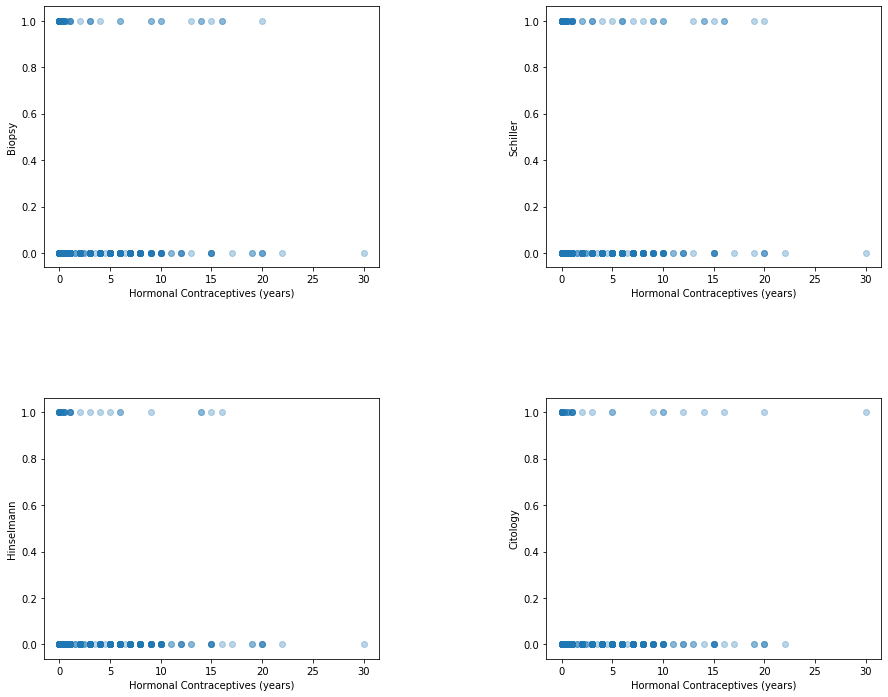

In [10]:
fig, ax = plt.subplots(figsize=(15,12))
ax = plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
ax = plt.subplot(2,2,1)
ax = plt.scatter(df['Hormonal Contraceptives (years)'], df['Biopsy'], alpha = 0.3)
ax = plt.xlabel("Hormonal Contraceptives (years)")
ax = plt.ylabel("Biopsy")

ax = plt.subplot(2,2,2)
ax = plt.scatter(df['Hormonal Contraceptives (years)'], df['Schiller'], alpha = 0.3)
ax = plt.xlabel("Hormonal Contraceptives (years)")
ax = plt.ylabel("Schiller")

ax = plt.subplot(2,2,3)
ax = plt.scatter(df['Hormonal Contraceptives (years)'], df['Hinselmann'], alpha = 0.3)
ax = plt.xlabel("Hormonal Contraceptives (years)")
ax = plt.ylabel("Hinselmann")

ax = plt.subplot(2,2,4)
ax = plt.scatter(df['Hormonal Contraceptives (years)'], df['Citology'], alpha = 0.3)
ax = plt.xlabel("Hormonal Contraceptives (years)")
ax = plt.ylabel("Citology")


In [11]:
# for example, selecting the Biopsy target variable
x_data = df['Hormonal Contraceptives (years)']
y_data = df['Biopsy'] 

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*x_data + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=y_data)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

C:\Users\Niv\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -210.08, ||grad|| = 1.5965: 100%|█████████████████████████████████████████████| 16/16 [00:00<00:00, 1608.13it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 482000/482000 [03:20<00:00, 2404.42draws/s]
The number of effective samples is smaller than 10% for some parameters.


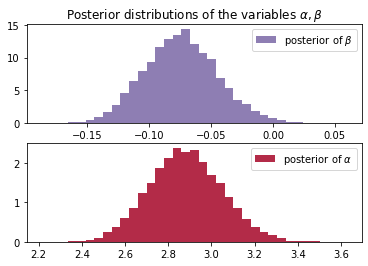

In [12]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

In [13]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(0, x_data.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

Text(0.5, 1.0, 'Posterior probability estimates given Hormonal Contracptives [years]')

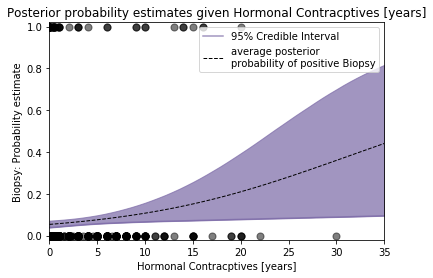

In [14]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "credible interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% Credible Interval", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of positive Biopsy")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(x_data, y_data, color="k", s=50, alpha=0.5)
plt.xlabel("Hormonal Contracptives [years]")
plt.ylabel("Biopsy: Probability estimate")
plt.title("Posterior probability estimates given Hormonal Contracptives [years]")

Unfortunately, this does not appear to be a very useful model for this data. It does not give much insight into if there exists an inflection point for which hormonal contraceptive use significantly increases the risk for positive Biopsy. Perhaps another model would be more useful to find such a point?

Also, at some point the credible interval becomes so wide that the predictive power of the model is really insignificant.